<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [247]:
import itertools
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [248]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-03-15 18:07:10--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-03-15 18:07:10 (11.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [249]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [250]:
df.shape

(346, 10)

### Convert to date time object 

In [251]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])

In [252]:
df['dayofweek'] = df['effective_date'].dt.dayofweek

# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [253]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [254]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
seaborn                   0.9.0                    py35_0    anaconda


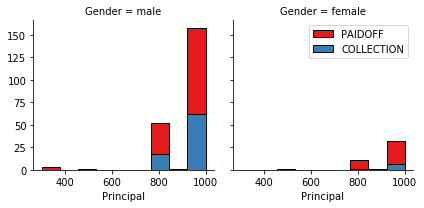

In [255]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

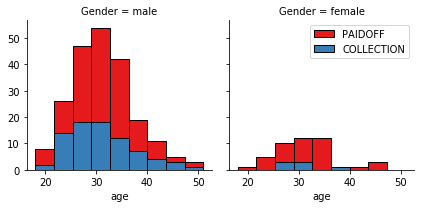

In [256]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

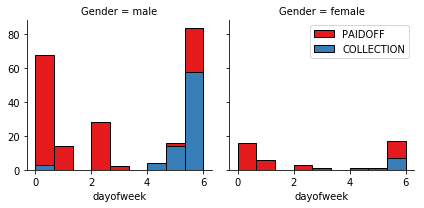

In [257]:
#df['dayofweek'] = df['effective_date'].dt.dayofweek          # copied this snippet to previous cell to look at it's impact and print df.head()
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [258]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

## Convert Categorical features to numerical values

Lets look at gender:

In [259]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [260]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

## One Hot Encoding  
#### How about education?

In [261]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [262]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [263]:
# check to see which of various columns are categorical
df.groupby(['Principal','terms'])['loan_status'].value_counts()

Principal  terms  loan_status
300        7      PAIDOFF          3
500        7      PAIDOFF          1
           15     PAIDOFF          1
800        7      PAIDOFF          1
           15     PAIDOFF         58
                  COLLECTION      17
           30     PAIDOFF          4
                  COLLECTION       1
900        7      PAIDOFF          1
           15     PAIDOFF          1
1000       7      PAIDOFF          8
           15     PAIDOFF         54
                  COLLECTION      17
           30     PAIDOFF        128
                  COLLECTION      51
Name: loan_status, dtype: int64

#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [264]:
# create at new df Feature as subset of entire df and including columns listed below
Feature = df[['Principal','terms','age','Gender','weekend']]
# modify the Feature df to add columns associated with the values in the education column and cast them as one-hot encoded (i.e. 1 in the colum that matches the value in the education column for that row)
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
# drop the Master or Above column from the Feature df
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [265]:
# explore what df features and target values look like
#df.columns[3:12]
#Feature.columns[:]
df['loan_status'].unique().tolist()
#type(df['loan_status'])

['PAIDOFF', 'COLLECTION']

### Feature selection

Lets define feature sets, X:

In [266]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [267]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [268]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [269]:
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

### Split the X and y datasets defined above and print the train and test array shapes

In [270]:
# split the X and y datasets defined above and print the train and test array shapes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)  # test size=0.2 gives k optimized to 19 which is too big, test_size=0.3 give k=5 which is better
print('Train sets shapes: ', X_train.shape, y_train.shape)
print('Test sets shapes:', X_test.shape, y_test.shape)

Train sets shapes:  (242, 8) (242,)
Test sets shapes: (104, 8) (104,)


### Import the K Nearest Neighbor (KNN) rom Scikit-Learn and Define Model

In [271]:
# import k nearest neighbor library
from sklearn.neighbors import KNeighborsClassifier

# start with k=4 and define and train KNN model
k=4
knn = KNeighborsClassifier(n_neighbors = k, metric='chebyshev').fit(X_train, y_train)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='chebyshev',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

### Use the KNN model to predict y hat

In [272]:
# use trained knn classifier to predict classification for test data
y_hat_knn = knn.predict(X_test)
y_hat_knn[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

### Evaluate the KNN model with Accuracy_Score and Jaccard_Similarity_Score metrics from Scikit-Learn (verify that they give the same results)

In [273]:
# evaluate model accuracy using accuracy_score which is equivalent to Jaccard Index
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
print('Testing set Jaccard accuracy:  ', jaccard_similarity_score(y_test, y_hat_knn), ' with k = ', k)
print('Training set Jaccard accuracy: ', jaccard_similarity_score(y_train, knn.predict(X_train)), ' with k = ', k)

Testing set Jaccard accuracy:   0.730769230769  with k =  4
Training set Jaccard accuracy:  0.780991735537  with k =  4


### Run the KNN model with various values of k

In [274]:
# evaluate model accuracy with other values for k from 1 to 10
k_max = 35
# generate test accuracy, jaccard, and standard deviation numpy arrays initiallized to all zeros
test_acc = np.zeros((k_max-1))
jacc_acc = np.zeros((k_max-1))
stdev_acc = np.zeros((k_max-1))
# loop through other k cases and update test accuracy and standard deviations arrays
for i in range(1,k_max):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    y_hat_knn = knn.predict(X_test)
    test_acc[i-1] = metrics.accuracy_score(y_test, y_hat_knn)
    jacc_acc[i-1] = metrics.jaccard_similarity_score(y_test, y_hat_knn)
    stdev_acc[i-1] = np.std(y_hat_knn == y_test)/np.sqrt(y_hat_knn.shape[0])
    #print('Testing set accuracy: ', round(test_acc[i-1], 6), ' with k = ', i)
#test_acc

### Determine the best value for k from a graph of accuracy vs k

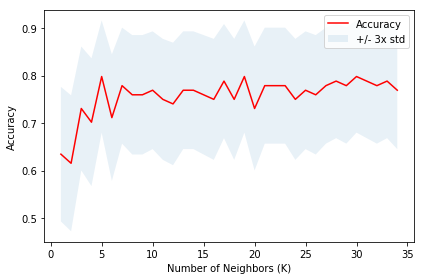

In [275]:
# plot accuracy as function of value of k
plt.plot(range(1,k_max), test_acc, 'r')
plt.fill_between(range(1,k_max), jacc_acc-1 * 3*stdev_acc, jacc_acc+1 * 3*stdev_acc, alpha=0.10)
plt.legend(('Accuracy', '+/- 3x std'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

### Print the KNN Accuracy and Jaccard index and the best value for k

In [276]:
print('The best test set accuracy was ', test_acc.max(), ' with k = ', test_acc.argmax()+1)
print('Testing set Jaccard index:     ', jacc_acc.max(), ' with k = ', jacc_acc.argmax()+1)

The best test set accuracy was  0.798076923077  with k =  5
Testing set Jaccard index:      0.798076923077  with k =  5


### Rerun the KNN model with best value for k

In [277]:
# set k equal to value identifed above and define and train KNN model
k = jacc_acc.argmax()+1
knn = KNeighborsClassifier(n_neighbors = k, metric='chebyshev').fit(X_train, y_train)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='chebyshev',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

### Use the KNN model again to predict y hat using all the X data

In [278]:
# use trained knn classifier to predict classification for all data (not just X_test)
y_hat_knn = knn.predict(X_test)
y_hat_knn[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

### Again print the KNN model Accuracy and Jaccard index and the value of k with all the X and y data

In [279]:
# evaluate model accuracy using accuracy_score which is equivalent to Jaccard Index
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
print('Testing set Jaccard accuracy:  ', jaccard_similarity_score(y_test, y_hat_knn), ' with k = ', k)
print('Training set Jaccard accuracy: ', jaccard_similarity_score(y_train, knn.predict(X_train)), ' with k = ', k)

Testing set Jaccard accuracy:   0.798076923077  with k =  5
Training set Jaccard accuracy:  0.797520661157  with k =  5


### Define and evalute the KNN model with Confusion Matrix and F1 Score

In [280]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(confusion_matrix(y_test, y_hat_knn))

[[10 14]
 [ 7 73]]


### Print the true and KNN predicted value counts

In [281]:
print('y_test = true label: ', '\n', pd.Series(y_test).value_counts(), '\n\n', 'y_hat_knn = predicted label: ', '\n', pd.Series(y_hat_knn).value_counts())

y_test = true label:  
 PAIDOFF       80
COLLECTION    24
dtype: int64 

 y_hat_knn = predicted label:  
 PAIDOFF       87
COLLECTION    17
dtype: int64


Confusion matrix, without normalization
[[10 14]
 [ 7 73]]


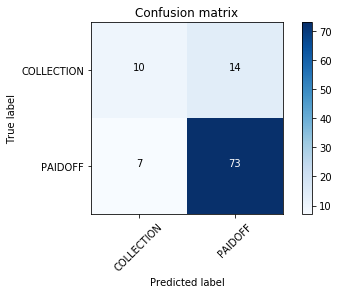

In [282]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_knn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'], normalize= False,  title='Confusion matrix')

The first row is for customers with loans that are actually in COLLECTION.  Of the 104 customers in the test set 24 are actually in COLLECTION.  Of these 24 actually in COLLECTION the model correctly predicted 12 in COLLECTION and incorrectly predicted 12 as PAIDOFF.

The second row is for customers with loans that are actually PAIDOFF.  Of the 104 customers in the test set 80 are actually PAIDOFF.  Of these 80 actually PAIDOFF the model correctly predicted 64 as PAIDOFF and incorrectly predicted 16 as in COLLECTION.

A confusion matrix shows the model’s ability to correctly predict or separate the classes.  These numbers can be interpreted as the count of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).

Based on the count of each section, we can calculate precision and recall of each label:


- __Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

- __Recall__ is true positive rate. It is defined as: Recall =  TP / (TP + FN)

    
So, we can calculate precision and recall of each class.

__F1 score:__
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label. 

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

In [283]:
print(classification_report(y_test, y_hat_knn), ' \n\n k = ' , k)

             precision    recall  f1-score   support

 COLLECTION       0.59      0.42      0.49        24
    PAIDOFF       0.84      0.91      0.87        80

avg / total       0.78      0.80      0.79       104
  

 k =  5


The avg / total values in this case are the weighted average where the weights are the support values.

For example for f1-score, (0.49 * 24 + 0.87 * 80) / 104 = 0.79

The average accuracy for this classifier is the weighted average of the F1-score for both labels, which is 0.79 in this case.

# Decision Tree

In [284]:
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

### Split the X and y datasets defined above and print the train and test array shapes

In [285]:
# split the X and y datasets defined above and print the train and test array shapes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('Train sets shapes: ', X_train.shape, y_train.shape)
print('Test sets shapes:', X_test.shape, y_test.shape)

Train sets shapes:  (276, 8) (276,)
Test sets shapes: (70, 8) (70,)


### Import DecisionTreeClassifier
Import DecisionTreeClassifier from sklearn.

In [286]:
from sklearn.tree import DecisionTreeClassifier

### Run the Decision Tree model with various max_depths

In [287]:
# evaluate model accuracy with other values for k from 1 to 10
depth_max = 35
# generate jaccard index arrays for test and train sets and initiallized to all zeros
jacc_acc_dtree = np.zeros((depth_max-1))
jacc_acc_train = np.zeros((depth_max-1))
# loop through various max_depths and update jaccard index arrays for test and train sets
for i in range(1,depth_max):
    loanTree = DecisionTreeClassifier(criterion='entropy', max_depth=i)     # define decision tree classifier; tried with class_weight='balanced' but worse results; also looked at criterion='gini'
    loanTree.fit(X_train, y_train)                                          # train decision tree classifier
    y_hat_dtree = loanTree.predict(X_test)                                  # predict from test set
    y_hat_train = loanTree.predict(X_train)                                 # predict from train set
    jacc_acc_dtree[i-1] = metrics.jaccard_similarity_score(y_test, y_hat_dtree)  # calculate test jaccard
    jacc_acc_train[i-1] = metrics.jaccard_similarity_score(y_train, y_hat_train) # calculate train jaccard
    #print('Testing set accuracy: ', round(test_acc[i-1], 6), ' with k = ', i)
#test_acc

### Determine the best max_depth from a graph of accuracy vs max depth

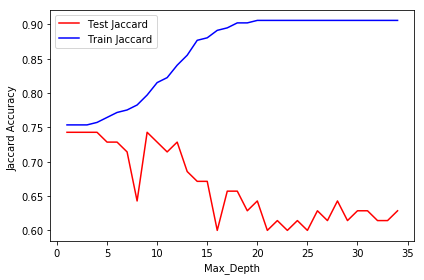

In [288]:
# plot train and test accuracy as function of max depth
plt.plot(range(1,depth_max), jacc_acc_dtree, 'r')
plt.plot(range(1,depth_max), jacc_acc_train, 'b')
plt.legend(('Test Jaccard', 'Train Jaccard'))
plt.ylabel('Jaccard Accuracy ')
plt.xlabel('Max_Depth')
plt.tight_layout()
plt.show()

In [289]:
print('Testing set Jaccard :       ', jacc_acc_dtree[8], ' with max_depth = 8')
print('Testing set Jaccard index:  ', jacc_acc_dtree.max(), ' with max_depth = ', jacc_acc_dtree.argmax()+1)
print('Training set Jaccard index: ', jacc_acc_train.max(), ' with max_depth = ', jacc_acc_train.argmax()+1)

Testing set Jaccard :        0.742857142857  with max_depth = 8
Testing set Jaccard index:   0.742857142857  with max_depth =  1
Training set Jaccard index:  0.905797101449  with max_depth =  20


max_depth of 1 is not a good choice. jaccard index is same value for several max_depths. choose max_depth=8

### Model with Decision Tree

In [290]:
loanTree = DecisionTreeClassifier(criterion='entropy', max_depth=8)
loanTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [291]:
loanTree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [292]:
predLoan = loanTree.predict(X_test)

### Explore model results compared to true values

In [293]:
predLoan[0:5]

array(['COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

### Evaluate the Decision Tree model with Accuracy_Score and Jaccard_Similarity_Score metrics from Scikit-Learn (verify that they give the same results)

In [294]:
# evaluate model accuracy using accuracy_score which is equivalent to Jaccard Index
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
print('Testing set Jaccard index:  ', jaccard_similarity_score(y_test, predLoan))
print('Training set Jaccard index: ', jaccard_similarity_score(y_train, loanTree.predict(X_train)))

Testing set Jaccard index:   0.642857142857
Training set Jaccard index:  0.782608695652


In [295]:
print('y_test = true label: ', '\n', pd.Series(y_test).value_counts(), '\n\n', 'predLoan = predicted label: ', '\n', pd.Series(predLoan).value_counts())

y_test = true label:  
 PAIDOFF       52
COLLECTION    18
dtype: int64 

 predLoan = predicted label:  
 PAIDOFF       49
COLLECTION    21
dtype: int64


### Define and evalute the Decision Tree model with Confusion Matrix and F1 Score

In [296]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(confusion_matrix(y_test, predLoan))

[[ 7 11]
 [14 38]]


Confusion matrix, without normalization
[[ 7 11]
 [14 38]]


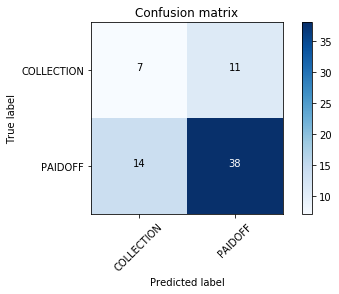

In [297]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predLoan)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'], normalize= False,  title='Confusion matrix')

The first row is for customers with loans that are actually in COLLECTION.  Of the 70 customers in the test set 18 are actually in COLLECTION.  Of these 18 actually in COLLECTION the model correctly predicted 7 in COLLECTION and incorrectly predicted 11 as PAIDOFF.

The second row is for customers with loans that are actually PAIDOFF.  Of the 70 customers in the test set 52 are actually PAIDOFF.  Of these 52 actually PAIDOFF the model correctly predicted 38 as PAIDOFF and incorrectly predicted 14 as in COLLECTION.

A confusion matrix shows the model’s ability to correctly predict or separate the classes.  These numbers can be interpreted as the count of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).

### Evaluate Decision Tree Model

In [298]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTree's Accuracy with Jaccard index: ", jaccard_similarity_score(y_test, predLoan))

DecisionTree's Accuracy with Jaccard index:  0.642857142857


In [299]:
print(classification_report(y_test, predLoan))

             precision    recall  f1-score   support

 COLLECTION       0.33      0.39      0.36        18
    PAIDOFF       0.78      0.73      0.75        52

avg / total       0.66      0.64      0.65        70



The avg / total values in this case are the weighted average where the weights are the support values.

For example for F1-score, (0.36 * 18 + 0.75 * 52) / 70 = 0.65

The average accuracy for this classifier is the average of the F1-score for both labels, which is 0.65 in this case.

### Visualize Decision Tree

Install and import packages to visualize decision tree

In [300]:
 !conda install -c conda-forge pydotplus -y
 !conda install -c conda-forge python-graphviz -y

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
pydotplus                 2.0.2                      py_2    conda-forge
Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
python-graphviz           0.10.1                     py_0    conda-forge


In [301]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

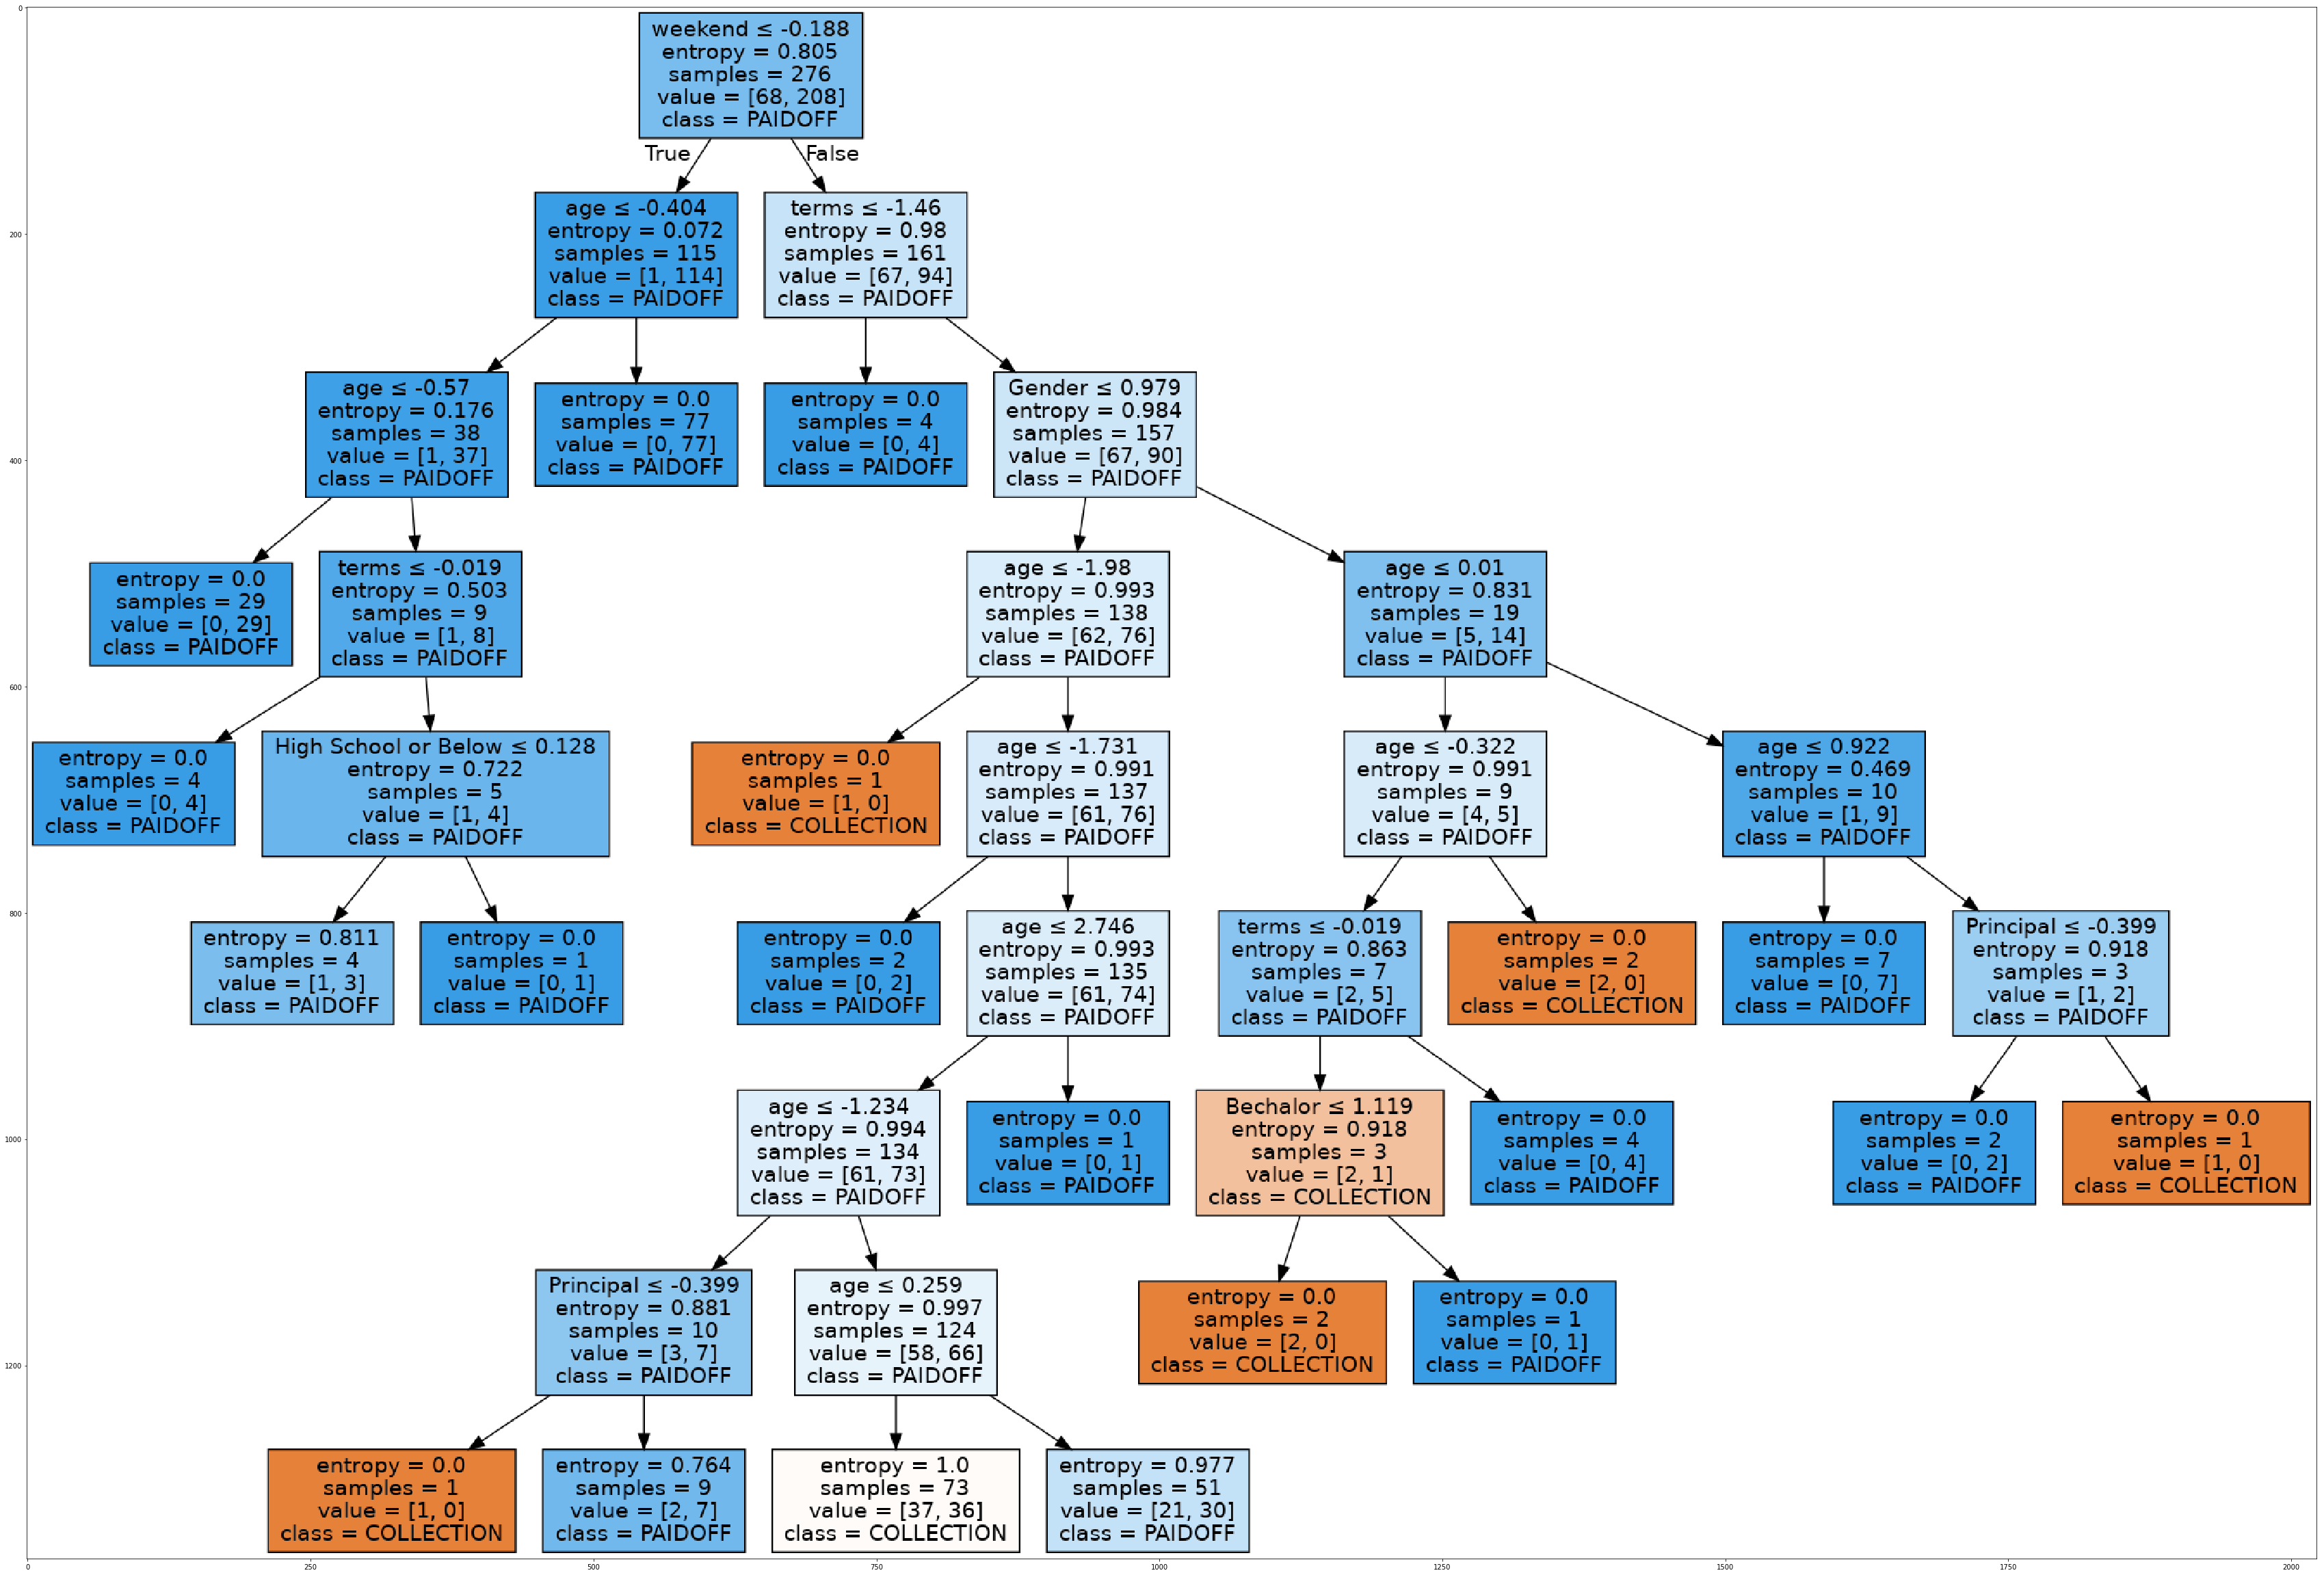

In [302]:
# visualize decision tree with full non-normalized data set
dot_data = StringIO()
filename = "loanTree.png"
 # Feature.columns[:] is type pandas.core.indexes.base.Index. Feature = df[['Principal','terms','age','Gender','weekend']] and Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
featureNames = Feature.columns[:]
# df['loan_status'].unique.tolist() is type list (obviously). df['loan_status'] is the label, category, y value from the data frame.
targetNames = df['loan_status'].unique().tolist()
targetNames = y_test.tolist()
out=tree.export_graphviz(loanTree, feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_test), filled=True,  special_characters=True, rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(60, 120))
plt.imshow(img, interpolation='nearest')

# Support Vector Machine

### Import library

In [303]:
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing

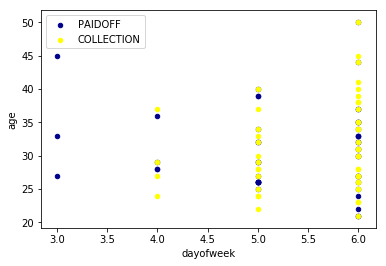

In [304]:
# plot loan status vs age and day of week
ax = df[df['loan_status'] == 'PAIDOFF'][0:50].plot(kind='scatter', x='dayofweek', y='age', color='DarkBlue', label='PAIDOFF');
df[df['loan_status'] == 'COLLECTION'][0:50].plot(kind='scatter', x='dayofweek', y='age', color='Yellow', label='COLLECTION', ax=ax);
plt.show()

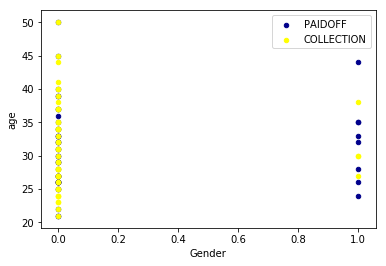

In [305]:
# plot loan status vs gender and age
ax = df[df['loan_status'] == 'PAIDOFF'][0:50].plot(kind='scatter', x='Gender', y='age', color='DarkBlue', label='PAIDOFF');
df[df['loan_status'] == 'COLLECTION'][0:50].plot(kind='scatter', x='Gender', y='age', color='Yellow', label='COLLECTION', ax=ax);
plt.show()

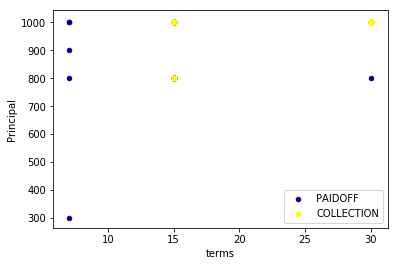

In [306]:
# plot loan status vs terms and Principal
ax = df[df['loan_status'] == 'PAIDOFF'][0:50].plot(kind='scatter', x='terms', y='Principal', color='DarkBlue', label='PAIDOFF');
df[df['loan_status'] == 'COLLECTION'][0:50].plot(kind='scatter', x='terms', y='Principal', color='Yellow', label='COLLECTION', ax=ax);
plt.show()

### Split the X and y datasets defined above and print the train and test array shapes

In [307]:
# split the X and y datasets defined above and print the train and test array shapes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('Train sets shapes: ', X_train.shape, y_train.shape)
print('Test sets shapes:', X_test.shape, y_test.shape)

Train sets shapes:  (276, 8) (276,)
Test sets shapes: (70, 8) (70,)


### Import SVM and Fit SVM Model

In [308]:
from sklearn import svm
hyperplane = svm.SVC(C=1.0, kernel='rbf')      # gives better final results with train/test Jaccard = 0.765 & 0.743 & F1 = 0.63 but final test set SVM Jaccard = 0.722 F1 = 0.621
#hyperplane = svm.SVC(C=1.0, kernel='poly')    # gives better results in train/test Jaccard = 0.786 & 0.757 & F1 = 0.69 but worse on final test set with SVM Jaccard = 0.685 F1 = 0.602
hyperplane.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [309]:
y_pred_svm = hyperplane.predict(X_test)
y_pred_svm[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

### Define and evalute the SVM model with Confusion Matrix and F1 Score

In [310]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(confusion_matrix(y_test, y_pred_svm))

[[ 0 18]
 [ 0 52]]


### Evaluate the Decision Tree model with Accuracy_Score and Jaccard_Similarity_Score metrics from Scikit-Learn (verify that they give the same results)

In [311]:
# evaluate model accuracy using accuracy_score which is equivalent to Jaccard Index
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
print('Testing set Jaccard:  ', jaccard_similarity_score(y_test, y_pred_svm))
print('Training set Jaccard: ', jaccard_similarity_score(y_train, hyperplane.predict(X_train)))

Testing set Jaccard:   0.742857142857
Training set Jaccard:  0.764492753623


### Print the true and SVM predicted value counts

In [312]:
print('y_test = true label: ', '\n', pd.Series(y_test).value_counts(), '\n\n', 'y_pred_svm = predicted label: ', '\n', pd.Series(y_pred_svm).value_counts())

y_test = true label:  
 PAIDOFF       52
COLLECTION    18
dtype: int64 

 y_pred_svm = predicted label:  
 PAIDOFF    70
dtype: int64


### Print the SVM Model Confustion Matrix Graphic and F1 Score

Confusion matrix, without normalization
[[ 0 18]
 [ 0 52]]


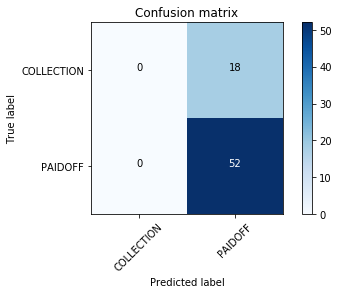

In [313]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'], normalize= False,  title='Confusion matrix')

The first row is for customers with loans that are actually in COLLECTION.  Of the 70 customers 18 are actually in COLLECTION.  Of these 18 actually in COLLECTION the model predicted none as in COLLECTION and incorrectly predicted 18 as PAIDOFF.

The second row is for customers with loans that are actually PAIDOFF.  Of the 70 customers 52 are actually PAIDOFF.  Of these 52 actually PAIDOFF the model correctly predicted 52 as PAIDOFF and predicted none as in COLLECTION.

A confusion matrix shows the model’s ability to correctly predict or separate the classes.  These numbers can be interpreted as the count of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).

Based on the count of each section, we can calculate precision and recall of each label:


- __Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

- __Recall__ is true positive rate. It is defined as: Recall =  TP / (TP + FN)

    
So, we can calculate precision and recall of each class.

__F1 score:__
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label. 

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

In [314]:
print(classification_report(y_test, y_pred_svm))

             precision    recall  f1-score   support

 COLLECTION       0.00      0.00      0.00        18
    PAIDOFF       0.74      1.00      0.85        52

avg / total       0.55      0.74      0.63        70



/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The avg / total values in this case are the weighted average where the weights are the support values.

For example for F1-score, (0.00 * 18 + 0.85 * 52) / 70 = 0.63

The average accuracy for this classifier is the average of the F1-score for both labels, which is 0.63 in this case.

### Print the SVM Model Accuracy and Jaccard Index

In [315]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("SVM Test set Jaccard: ", jaccard_similarity_score(y_test, y_pred_svm))

SVM Test set Jaccard:  0.742857142857


# Logistic Regression

### Import library

In [316]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

### Load data from csv file

In [317]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-03-15 18:09:49--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.005s  

2019-03-15 18:09:49 (4.27 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [318]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


#### Convert to date time object 

In [319]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
#df.head()

#### Create day of the week based on effective date

In [320]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
#df.head()

#### Identify weekend based on day of the week data

In [321]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
#df.head()

#### Convert gender and loan status to binary integer values

In [322]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#df[258:262]

In [323]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0], inplace=True)

#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [324]:
# create at new df Feature as subset of entire df and including columns listed below
Feature = df[['Principal','terms','age','Gender','weekend']]
# modify the Feature df to add columns associated with the values in the education column and cast them as one-hot encoded (i.e. 1 in the colum that matches the value in the education column for that row)
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
# drop the Master or Above column from the Feature df
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [325]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [326]:
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

### Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [327]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [328]:
y[250:270]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Split the X and y datasets defined above and print the train and test array shapes

In [329]:
# split the X and y datasets defined above and print the train and test array shapes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('Train sets shapes: ', X_train.shape, y_train.shape)
print('Test sets shapes:', X_test.shape, y_test.shape)

Train sets shapes:  (276, 8) (276,)
Test sets shapes: (70, 8) (70,)


### Model with Logistic Regression

In [330]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LogReg = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LogReg

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Predict with Logistic Regression

In [331]:
y_hat_LogReg = LogReg.predict(X_test)
y_hat_LogReg[0:5]

array([1, 1, 0, 1, 1])

#### Get Probability Prediction

In [332]:
y_hat_LogReg_prob = LogReg.predict_proba(X_test)
y_hat_LogReg_prob[0:5]

array([[ 0.49,  0.51],
       [ 0.29,  0.71],
       [ 0.5 ,  0.5 ],
       [ 0.49,  0.51],
       [ 0.49,  0.51]])

In [333]:
y_train[0:5]

array([1, 1, 1, 0, 0])

In [334]:
y_test[0:5]

array([0, 0, 0, 1, 0])

#### Evaluate the Logistic Regression model with Accuracy_Score and Jaccard_Similarity_Score metrics from Scikit-Learn (verify that they give the same results)

In [335]:
# evaluate model accuracy using accuracy_score which is equivalent to Jaccard Index
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
print('Testing set Jaccard index:  ', jaccard_similarity_score(y_test, y_hat_LogReg))
print('Training set Jaccard index: ', jaccard_similarity_score(y_train, LogReg.predict(X_train)))

Testing set Jaccard index:   0.757142857143
Training set Jaccard index:  0.760869565217


#### Print the true and Logistic Regression predicted value counts

In [336]:
y_test = pd.Series(y_test)
y_hat_LogReg = pd.Series(y_hat_LogReg)
y_test.replace(to_replace=[0,1], value=['COLLECTION','PAIDOFF'], inplace=True)
y_hat_LogReg.replace(to_replace=[0,1], value=['COLLECTION','PAIDOFF'], inplace=True)
print('y_test = true label: ', '\n', y_test.value_counts(), '\n\n', 'y_pred_svm = predicted label: ', '\n', y_hat_LogReg.value_counts())

y_test = true label:  
 PAIDOFF       52
COLLECTION    18
dtype: int64 

 y_pred_svm = predicted label:  
 PAIDOFF       67
COLLECTION     3
dtype: int64


### Define and evalute the Logistic Regression model with Confusion Matrix and F1 Score

In [337]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(confusion_matrix(y_test, y_hat_LogReg))

[[ 2 16]
 [ 1 51]]


### Print the Logistic Regression Model Confustion Matrix Graphic and F1 Score

Confusion matrix, without normalization
[[ 2 16]
 [ 1 51]]


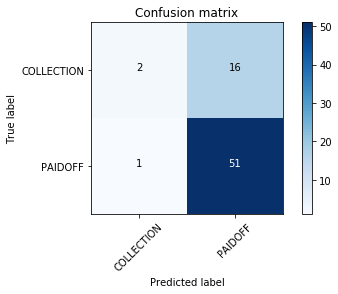

In [338]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_LogReg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'], normalize= False,  title='Confusion matrix')

The first row is for customers with loans that are actually in COLLECTION.  Of the 70 customers 18 are actually in COLLECTION.  Of these 18 actually in COLLECTION the model correctly predicted 2 in COLLECTION and incorrectly predicted all 16 as PAIDOFF.

The second row is for customers with loans that are actually PAIDOFF.  Of the 70 customers 52 are actually PAIDOFF.  Of these 52 actually PAIDOFF the model correctly predicted 51 as PAIDOFF and incorrectly predicted 1 as in COLLECTION.

A confusion matrix shows the model’s ability to correctly predict or separate the classes.  These numbers can be interpreted as the count of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).

Based on the count of each section, we can calculate precision and recall of each label:


- __Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

- __Recall__ is true positive rate. It is defined as: Recall =  TP / (TP + FN)

    
So, we can calculate precision and recall of each class.

__F1 score:__
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label. 

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

In [339]:
print(classification_report(y_test, y_hat_LogReg))

             precision    recall  f1-score   support

 COLLECTION       0.67      0.11      0.19        18
    PAIDOFF       0.76      0.98      0.86        52

avg / total       0.74      0.76      0.69        70



The avg / total values in this case are the weighted average where the weights are the support values.

For example for F1-score, (0.19 * 18 + 0.86 * 52) / 70 = 0.69

The average accuracy for this classifier is the average of the F1-score for both labels, which is 0.69 in this case.

### Print the Logistic Regression Model Jaccard Index

In [340]:
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
import matplotlib.pyplot as plt
print("Logistic Regression Jaccard: ", jaccard_similarity_score(y_test, y_hat_LogReg))

Logistic Regression Jaccard:  0.757142857143


### log loss
Now, lets try __log loss__ for evaluation. In logistic regression, the output can be the probability of PAIDOFF is TRUE (or equals to 1). This probability is a value between 0 and 1.
Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1. 


In [341]:
from sklearn.metrics import log_loss
print("Logistic Regression Log Loss : ", log_loss(y_test, y_hat_LogReg_prob))

Logistic Regression Log Loss :  0.583810652022


# Model Evaluation using Test set

In [342]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Load Test set for evaluation 

First, download and load the test set:

In [343]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-03-15 18:09:50--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-03-15 18:09:50 (613 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [344]:
test_df = pd.read_csv('loan_test.csv')

### Convert to date time object 

In [345]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

In [346]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

In [347]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [348]:
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6


### Visualizations to explore test data set

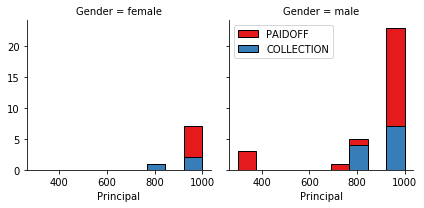

In [349]:
import seaborn as sns

bins = np.linspace(test_df.Principal.min(), test_df.Principal.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

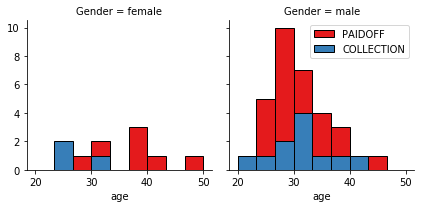

In [350]:
bins = np.linspace(test_df.age.min(), test_df.age.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

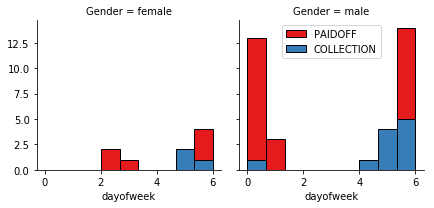

In [351]:
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [352]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

## Convert Categorical features to numerical values

In [353]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

Lets convert male to 0 and female to 1:


In [354]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

## One Hot Encoding  
#### How about education?

In [355]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [356]:
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [357]:
# check to see which of various columns are categorical
test_df.groupby(['Principal','terms'])['loan_status'].value_counts()

Principal  terms  loan_status
300        7      PAIDOFF         3
700        15     PAIDOFF         1
800        15     COLLECTION      5
                  PAIDOFF         5
           30     PAIDOFF         1
1000       7      PAIDOFF         3
           15     PAIDOFF         7
                  COLLECTION      2
           30     PAIDOFF        20
                  COLLECTION      7
Name: loan_status, dtype: int64

#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [358]:
# create at new df Feature as subset of entire df and including columns listed below
Test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
# modify the Feature df to add columns associated with the values in the education column and cast them as one-hot encoded (i.e. 1 in the colum that matches the value in the education column for that row)
Test_Feature = pd.concat([Test_Feature,pd.get_dummies(test_df['education'])], axis=1)
# drop the Master or Above column from the Feature df
Test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
Test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


### Feature selection

Lets define test set feature, TSX:

In [359]:
TSX = Test_Feature

And test set lables, tsy:

In [360]:
tsy = test_df['loan_status'].values

### Normalize Data 

Data Standardization give data zero mean and unit variance:

In [361]:
TSX = preprocessing.StandardScaler().fit(TSX).transform(TSX)

### Use the KNN model to predict the test set y hat

In [362]:
# use trained knn classifier to predict classification for test data
tsy_hat_knn = knn.predict(TSX)

### Calculate the KNN model Jaccard index and F1-Score

In [363]:
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
knn_jac = '%.3f' % jaccard_similarity_score(tsy,tsy_hat_knn)
knn_f1 = '%.3f' % sklearn.metrics.f1_score(tsy, tsy_hat_knn, average='weighted')

In [364]:
print(knn_jac, knn_f1)

0.704 0.658


### Use the Decision Tree model to predict the test set y hat

In [365]:
# use the trained decision tree classifier to predict classification for test data
tsy_hat_dtree = loanTree.predict(TSX)

### Calculate the Desision Tree model Jaccard index and F1-Score

In [366]:
dtree_jac = '%.3f' % jaccard_similarity_score(tsy, tsy_hat_dtree)
dtree_f1 = '%.3f' % sklearn.metrics.f1_score(tsy, tsy_hat_dtree, average='weighted')

### Use the SVM model to predict the test set y hat

In [367]:
tsy_hat_svm = hyperplane.predict(TSX)

### Calculate the SVM model Jaccard index and F1-Score

In [368]:
svm_jac = '%.3f' % jaccard_similarity_score(tsy, tsy_hat_svm)
svm_f1 = '%.3f' % sklearn.metrics.f1_score(tsy, tsy_hat_svm, average='weighted')

### Use the Logistic Regression model to predict the test set y hat

In [369]:
tsy_hat_LogReg = LogReg.predict(TSX)

In [370]:
tsy_hat_LogReg[0:5]    # predicted values are binary integers 0 or 1

array([1, 1, 1, 1, 1])

In [371]:
# convert predicted values from binary integers to PAIDOFF or COLLECTION
tsy_hat_LogReg = pd.Series(tsy_hat_LogReg)
tsy_hat_LogReg.replace(to_replace=[0,1], value=['COLLECTION','PAIDOFF'], inplace=True)
tsy_hat_LogReg[0:5]

0    PAIDOFF
1    PAIDOFF
2    PAIDOFF
3    PAIDOFF
4    PAIDOFF
dtype: object

In [372]:
tsy[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

### Calculate the Logistic Regression model Jaccard index, F1-Score, and Log Loss

In [373]:
logreg_jac = '%.3f' % jaccard_similarity_score(tsy, tsy_hat_LogReg)
logreg_f1 = '%.3f' % sklearn.metrics.f1_score(tsy, tsy_hat_LogReg, average='weighted')

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Get Probability Prediction

In [374]:
tsy_hat_LogReg_prob = LogReg.predict_proba(TSX)
tsy_hat_LogReg_prob[0:5]

array([[ 0.25,  0.75],
       [ 0.42,  0.58],
       [ 0.41,  0.59],
       [ 0.5 ,  0.5 ],
       [ 0.46,  0.54]])

In [375]:
from sklearn.metrics import log_loss
logreg_logloss = '%.3f' % log_loss(tsy, tsy_hat_LogReg_prob)

### Create blank results report

In [376]:
dict_result = {'Algorithm': pd.Series(['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']), 'Jaccard' : pd.Series([]), 'F1-Score' : pd.Series([]), 'LogLoss' : pd.Series(['NA', 'NA', 'NA'])}
result_report = pd.DataFrame(dict_result, columns=['Algorithm','Jaccard','F1-Score','LogLoss'])
result_report.set_index('Algorithm', inplace=True)
result_report.loc[['KNN'],['Jaccard']] = knn_jac
result_report.loc[['KNN'],['F1-Score']] = knn_f1
result_report.loc[['Decision Tree'],['Jaccard']] = dtree_jac
result_report.loc[['Decision Tree'],['F1-Score']] = dtree_f1
result_report.loc[['SVM'],['Jaccard']] = svm_jac
result_report.loc[['SVM'],['F1-Score']] = svm_f1
result_report.loc[['Logistic Regression'],['Jaccard']] = logreg_jac
result_report.loc[['Logistic Regression'],['F1-Score']] = logreg_f1
result_report.loc[['Logistic Regression'],['LogLoss']] = logreg_logloss
result_report

,Jaccard,F1-Score,LogLoss
Algorithm,,,
KNN,0.704,0.658,NA
Decision Tree,0.704,0.718,NA
SVM,0.722,0.621,NA
Logistic Regression,0.741,0.630,0.573


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>